In [1]:
import sys
sys.path.append('../')
import os
os.environ["CUDA_VISIBLE_DEVICES"]="1"
import glob

from keras.optimizers import Adam, SGD
from keras.callbacks import ModelCheckpoint, LearningRateScheduler, TerminateOnNaN, CSVLogger, TensorBoard
from keras import backend as K
from keras.models import load_model
from math import ceil
import numpy as np
from matplotlib import pyplot as plt

from models.keras_ssd300_Siamese import ssd_300
from keras_loss_function.keras_ssd_loss import SSDLoss
from keras_layers.keras_layer_AnchorBoxes import AnchorBoxes
from keras_layers.keras_layer_DecodeDetections import DecodeDetections
from keras_layers.keras_layer_DecodeDetectionsFast import DecodeDetectionsFast
from keras_layers.keras_layer_L2Normalization import L2Normalization

from ssd_encoder_decoder.ssd_input_encoder import SSDInputEncoder
from ssd_encoder_decoder.ssd_output_decoder import decode_detections, decode_detections_fast

from data_generator.object_detection_2d_data_generator import DataGenerator
from data_generator.object_detection_2d_geometric_ops import Resize
from data_generator.object_detection_2d_photometric_ops import ConvertTo3Channels
from data_generator.data_augmentation_chain_original_ssd import SSDDataAugmentation, SSDDataAugmentation_Siamese
from data_generator.object_detection_2d_misc_utils import apply_inverse_transforms


img_height = 300 # Height of the model input images
img_width = 300 # Width of the model input images
img_channels = 3 # Number of color channels of the model input images
mean_color = [123, 117, 104] # Per-channel mean of images. Do not change if use any of the pre-trained weights.
# The color channel order in the original SSD is BGR,
# so we'll have the model reverse the color channel order of the input images.
swap_channels = [2, 1, 0]
classes = ['background',
           'person', 'rider', 'car', 'truck',
           'bus', 'train', 'motorcycle', 'bicycle']
n_classes = len(classes) - 1  # Number of positive classes, 8 for domain Cityscapes, 20 for Pascal VOC, 80 for MS COCO
# The anchor box scaling factors used in the original SSD300 for the Pascal VOC datasets
# scales_pascal = [0.1, 0.2, 0.37, 0.54, 0.71, 0.88, 1.05]
# The anchor box scaling factors used in the original SSD300 for the MS COCO datasets
scales_coco = [0.07, 0.15, 0.33, 0.51, 0.69, 0.87, 1.05]
scales = scales_coco
aspect_ratios = [[1.0, 2.0, 0.5],
                 [1.0, 2.0, 0.5, 3.0, 1.0/3.0],
                 [1.0, 2.0, 0.5, 3.0, 1.0/3.0],
                 [1.0, 2.0, 0.5, 3.0, 1.0/3.0],
                 [1.0, 2.0, 0.5],
                 [1.0, 2.0, 0.5]] # The anchor box aspect ratios used in the original SSD300; the order matters
two_boxes_for_ar1 = True
steps = [8, 16, 32, 64, 100, 300] # The space between two adjacent anchor box center points for each predictor layer.
# The offsets of the first anchor box center points from the top and left borders of the image
# as a fraction of the step size for each predictor layer.
offsets = [0.5, 0.5, 0.5, 0.5, 0.5, 0.5]
clip_boxes = False # Whether or not to clip the anchor boxes to lie entirely within the image boundaries
# The variances by which the encoded target coordinates are divided as in the original implementation
variances = [0.1, 0.1, 0.2, 0.2]
normalize_coords = True
Model_Build = 'New_Model'  # 'Load_Model'
Optimizer_Type = 'SGD'  # 'Adam' #  
batch_size = 16  # Change the batch size if you like, or if you run into GPU memory issues.
# alpha_distance =  0.001  # Coefficient for the distance between the source and target feature maps.
loss_weights = [0.00001, 0.00001, 0.00001] + [0.0, 0.0, 0.0, 0.0, 0.0, 0.0] + [1.0]
Source_Only = False

if len(glob.glob('*.h5')):
    Dataset_Build = 'Load_Dataset'
else:
    Dataset_Build = 'New_Dataset'

/usr/local/lib/python3.5/dist-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
if Model_Build == 'New_Model':
    # 1: Build the Keras model.

    K.clear_session()  # Clear previous models from memory.

    import tensorflow as tf
    from keras.backend.tensorflow_backend import set_session
    
    config = tf.ConfigProto()
    config.gpu_options.allow_growth = True  # dynamically grow the memory used on the GPU
    config.log_device_placement = True  # to log device placement (on which device the operation ran)
    # (nothing gets printed in Jupyter, only if you run it standalone)
    sess = tf.Session(config=config)
    set_session(sess)  # set this TensorFlow session as the default session for Keras

    model = ssd_300(image_size=(img_height, img_width, img_channels),
                    n_classes=n_classes,
                    mode='training',
                    l2_regularization=0.0005,
                    scales=scales,
                    aspect_ratios_per_layer=aspect_ratios,
                    two_boxes_for_ar1=two_boxes_for_ar1,
                    steps=steps,
                    offsets=offsets,
                    clip_boxes=clip_boxes,
                    variances=variances,
                    normalize_coords=normalize_coords,
                    subtract_mean=mean_color,
                    swap_channels=swap_channels)

    # 2: Load some weights into the model.

    # TODO: Set the path to the weights you want to load.
    weights_path = '../trained_weights/VGG_ILSVRC_16_layers_fc_reduced.h5'

    model.load_weights(weights_path, by_name=True)

    # 3: Instantiate an optimizer and the SSD loss function and compile the model.
    #    If you want to follow the original Caffe implementation, use the preset SGD
    #    optimizer, otherwise I'd recommend the commented-out Adam optimizer.

    if Optimizer_Type == 'SGD':
        Optimizer = SGD(lr=0.001, momentum=0.9, decay=0.0, nesterov=False)
    elif Optimizer_Type == 'Adam':
        Optimizer = Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0)
    else:
        raise ValueError('Undefined Optimizer_Type.')

    ssd_loss = SSDLoss(neg_pos_ratio=3, alpha=1.0)

    if Source_Only:
        model.compile(optimizer=Optimizer, loss={'pool1_GAP_substract': ssd_loss.compute_distance_loss_source_only,
                                                 'pool2_GAP_substract': ssd_loss.compute_distance_loss_source_only,
                                                 'pool3_GAP_substract': ssd_loss.compute_distance_loss_source_only,
                                                 'conv4_3_norm_GAP_substract': ssd_loss.compute_distance_loss_source_only,
                                                 'fc7_GAP_substract': ssd_loss.compute_distance_loss_source_only,
                                                 'conv6_2_GAP_substract': ssd_loss.compute_distance_loss_source_only,
                                                 'conv7_2_GAP_substract': ssd_loss.compute_distance_loss_source_only,
                                                 'conv8_2_GAP_substract': ssd_loss.compute_distance_loss_source_only,
                                                 'conv9_2_GAP_substract': ssd_loss.compute_distance_loss_source_only,
                                                 'predictions': ssd_loss.compute_loss},
                      loss_weights={'pool1_GAP_substract': loss_weights[0],
                                    'pool2_GAP_substract': loss_weights[1],
                                    'pool3_GAP_substract': loss_weights[2],
                                    'conv4_3_norm_GAP_substract': loss_weights[3],
                                    'fc7_GAP_substract': loss_weights[4],
                                    'conv6_2_GAP_substract': loss_weights[5],
                                    'conv7_2_GAP_substract': loss_weights[6],
                                    'conv8_2_GAP_substract': loss_weights[7],
                                    'conv9_2_GAP_substract': loss_weights[8],
                                    'predictions': loss_weights[9]})
    else:
        model.compile(optimizer=Optimizer, loss={'pool1_GAP_substract': ssd_loss.compute_distance_loss,
                                                 'pool2_GAP_substract': ssd_loss.compute_distance_loss,
                                                 'pool3_GAP_substract': ssd_loss.compute_distance_loss,
                                                 'conv4_3_norm_GAP_substract': ssd_loss.compute_distance_loss,
                                                 'fc7_GAP_substract': ssd_loss.compute_distance_loss,
                                                 'conv6_2_GAP_substract': ssd_loss.compute_distance_loss,
                                                 'conv7_2_GAP_substract': ssd_loss.compute_distance_loss,
                                                 'conv8_2_GAP_substract': ssd_loss.compute_distance_loss,
                                                 'conv9_2_GAP_substract': ssd_loss.compute_distance_loss,
                                                 'predictions': ssd_loss.compute_loss},
                      loss_weights={'pool1_GAP_substract': loss_weights[0],
                                    'pool2_GAP_substract': loss_weights[1],
                                    'pool3_GAP_substract': loss_weights[2],
                                    'conv4_3_norm_GAP_substract': loss_weights[3],
                                    'fc7_GAP_substract': loss_weights[4],
                                    'conv6_2_GAP_substract': loss_weights[5],
                                    'conv7_2_GAP_substract': loss_weights[6],
                                    'conv8_2_GAP_substract': loss_weights[7],
                                    'conv9_2_GAP_substract': loss_weights[8],
                                    'predictions': loss_weights[9]})
        
        
elif Model_Build == 'Load_Model':
    # TODO: Set the path to the `.h5` file of the model to be loaded.
    model_path = '../trained_weights/VGG_ssd300_Siamese_Cityscapes/epoch-23_loss-5.2110_val_loss-6.7452.h5'

    # We need to create an SSDLoss object in order to pass that to the model loader.
    ssd_loss = SSDLoss(neg_pos_ratio=3, alpha=1.0)

    K.clear_session()  # Clear previous models from memory.

    import tensorflow as tf
    from keras.backend.tensorflow_backend import set_session
    
    config = tf.ConfigProto()
    config.gpu_options.allow_growth = True  # dynamically grow the memory used on the GPU
    config.log_device_placement = True  # to log device placement (on which device the operation ran)
    # (nothing gets printed in Jupyter, only if you run it standalone)
    sess = tf.Session(config=config)
    set_session(sess)  # set this TensorFlow session as the default session for Keras

    model = load_model(model_path, custom_objects={'AnchorBoxes': AnchorBoxes,
                                                   'L2Normalization': L2Normalization,
                                                   'compute_loss': ssd_loss.compute_loss,
                                                   'compute_distance_loss': ssd_loss.compute_distance_loss})
else:
    raise ValueError('Undefined Model_Build. Model_Build should be New_Model  or Load_Model')

In [3]:
if Dataset_Build == 'New_Dataset':
    # 1: Instantiate two `DataGenerator` objects: One for training, one for validation.

    # Optional: If you have enough memory, consider loading the images into memory for the reasons explained above.

    train_dataset = DataGenerator(dataset='train', load_images_into_memory=False, hdf5_dataset_path=None)
    val_dataset = DataGenerator(dataset='val', load_images_into_memory=False, hdf5_dataset_path=None)

    # 2: Parse the image and label lists for the training and validation datasets. This can take a while.

    # TODO: Set the paths to the datasets here.

    # Introduction of PascalVOC: https://arleyzhang.github.io/articles/1dc20586/
    # The directories that contain the images.
    Cityscapes_images_dir = '../../datasets/Cityscapes/JPEGImages'
    Cityscapes_target_images_dir = '../../datasets/CITYSCAPES_beta_0_01/JPEGImages'

    # The directories that contain the annotations.
    Cityscapes_annotation_dir = '../../datasets/Cityscapes/Annotations'

    # The paths to the image sets.
    Cityscapes_train_source_image_set_filename = '../../datasets/Cityscapes/ImageSets/Main/train_source.txt'
    Cityscapes_train_target_image_set_filename = '../../datasets/Cityscapes/ImageSets/Main/train_target.txt'
    Cityscapes_test_target_image_set_filename = '../../datasets/Cityscapes/ImageSets/Main/test.txt'

    # images_dirs, image_set_filenames, and annotations_dirs should have the same length
    train_dataset.parse_xml(images_dirs=[Cityscapes_images_dir],
                            target_images_dirs=[Cityscapes_target_images_dir],
                            image_set_filenames=[Cityscapes_train_source_image_set_filename],
                            target_image_set_filenames=[Cityscapes_train_target_image_set_filename],
                            annotations_dirs=[Cityscapes_annotation_dir],
                            classes=classes,
                            include_classes='all',
                            exclude_truncated=False,
                            exclude_difficult=False,
                            ret=False)

    val_dataset.parse_xml(images_dirs=[Cityscapes_target_images_dir],
                          image_set_filenames=[Cityscapes_test_target_image_set_filename],
                          annotations_dirs=[Cityscapes_annotation_dir],
                          classes=classes,
                          include_classes='all',
                          exclude_truncated=False,
                          exclude_difficult=True,
                          ret=False)

    # Optional: Convert the dataset into an HDF5 dataset. This will require more disk space, but will
    # speed up the training. Doing this is not relevant in case you activated the `load_images_into_memory`
    # option in the constructor, because in that cas the images are in memory already anyway. If you don't
    # want to create HDF5 datasets, comment out the subsequent two function calls.

    # After create these h5 files, if you have resized the input image, you need to reload these files. Otherwise,
    # the images and the labels will not change.

    resize_image_to = (300, 600)
    train_dataset.create_hdf5_dataset(file_path='dataset_cityscapes_train.h5',
                                      resize=resize_image_to,
                                      variable_image_size=True,
                                      verbose=True)

    val_dataset.create_hdf5_dataset(file_path='dataset_cityscapes_test.h5',
                                    resize=resize_image_to,
                                    variable_image_size=True,
                                    verbose=True)

    train_dataset = DataGenerator(dataset='train',
                                  load_images_into_memory=False,
                                  hdf5_dataset_path='dataset_cityscapes_train.h5',
                                  filenames=Cityscapes_train_source_image_set_filename,
                                  target_filenames=Cityscapes_train_target_image_set_filename,
                                  filenames_type='text',
                                  images_dir=Cityscapes_images_dir,
                                  target_images_dir=Cityscapes_target_images_dir)

    val_dataset = DataGenerator(dataset='val',
                                load_images_into_memory=False,
                                hdf5_dataset_path='dataset_cityscapes_test.h5',
                                filenames=Cityscapes_test_target_image_set_filename,
                                filenames_type='text',
                                images_dir=Cityscapes_target_images_dir)

elif Dataset_Build == 'Load_Dataset':
    # 1: Instantiate two `DataGenerator` objects: One for training, one for validation.

    # Load dataset from the created h5 file.

    # The directories that contain the images.
    Cityscapes_images_dir = '../../datasets/Cityscapes/JPEGImages'
    Cityscapes_target_images_dir = '../../datasets/CITYSCAPES_beta_0_01/JPEGImages'

    # The paths to the image sets.
    Cityscapes_train_source_image_set_filename = '../../datasets/Cityscapes/ImageSets/Main/train_source.txt'
    Cityscapes_train_target_image_set_filename = '../../datasets/Cityscapes/ImageSets/Main/train_target.txt'
    Cityscapes_test_target_image_set_filename = '../../datasets/Cityscapes/ImageSets/Main/test.txt'

    train_dataset = DataGenerator(dataset='train',
                                  load_images_into_memory=False,
                                  hdf5_dataset_path='dataset_cityscapes_train.h5',
                                  filenames=Cityscapes_train_source_image_set_filename,
                                  target_filenames=Cityscapes_train_target_image_set_filename,
                                  filenames_type='text',
                                  images_dir=Cityscapes_images_dir,
                                  target_images_dir=Cityscapes_target_images_dir)

    val_dataset = DataGenerator(dataset='val',
                                load_images_into_memory=False,
                                hdf5_dataset_path='dataset_cityscapes_test.h5',
                                filenames=Cityscapes_test_target_image_set_filename,
                                filenames_type='text',
                                images_dir=Cityscapes_target_images_dir)

else:
    raise ValueError('Undefined Dataset_Build. Dataset_Build should be New_Dataset or Load_Dataset.')

Loading source image IDs: 100%|██████████| 493/493 [00:00<00:00, 11241.79it/s]
Loading target image IDs: 0it [00:00, ?it/s]
Loading evaluation-neutrality annotations: 100%|██████████| 493/493 [00:00<00:00, 6396.66it/s]


In [4]:
# 4: Set the image transformations for pre-processing and data augmentation options.

# For the training generator:
ssd_data_augmentation = SSDDataAugmentation_Siamese(img_height=img_height,
                                                    img_width=img_width)

# For the validation generator:
convert_to_3_channels = ConvertTo3Channels()
resize = Resize(height=img_height, width=img_width)

# 5: Instantiate an encoder that can encode ground truth labels into the format needed by the SSD loss function.

# The encoder constructor needs the spatial dimensions of the model's predictor layers to create the anchor boxes.
predictor_sizes = [model.get_layer('conv4_3_norm_mbox_conf').output_shape[1:3],
                   model.get_layer('fc7_mbox_conf').output_shape[1:3],
                   model.get_layer('conv6_2_mbox_conf').output_shape[1:3],
                   model.get_layer('conv7_2_mbox_conf').output_shape[1:3],
                   model.get_layer('conv8_2_mbox_conf').output_shape[1:3],
                   model.get_layer('conv9_2_mbox_conf').output_shape[1:3]]

ssd_input_encoder = SSDInputEncoder(img_height=img_height,
                                    img_width=img_width,
                                    n_classes=n_classes,
                                    predictor_sizes=predictor_sizes,
                                    scales=scales,
                                    aspect_ratios_per_layer=aspect_ratios,
                                    two_boxes_for_ar1=two_boxes_for_ar1,
                                    steps=steps,
                                    offsets=offsets,
                                    clip_boxes=clip_boxes,
                                    variances=variances,
                                    matching_type='multi',
                                    pos_iou_threshold=0.5,
                                    neg_iou_limit=0.5,
                                    normalize_coords=normalize_coords)

# 6: Create the generator handles that will be passed to Keras' `fit_generator()` function.
# The input image and label are first processed by transformations. Then, the label will be further encoded by
# ssd_input_encoder. The encoded labels are classId and offset to each anchor box.
train_generator = train_dataset.generate(batch_size=batch_size,
                                         shuffle=True,
                                         transformations=[ssd_data_augmentation],
                                         label_encoder=ssd_input_encoder,
                                         returns={'processed_images',
                                                  'encoded_labels'},
                                         keep_images_without_gt=False)

val_generator = val_dataset.generate(batch_size=batch_size,
                                     shuffle=False,
                                     transformations=[convert_to_3_channels,
                                                      resize],
                                     label_encoder=ssd_input_encoder,
                                     returns={'processed_images',
                                              'encoded_labels'},
                                     keep_images_without_gt=False)

# Get the number of samples in the training and validations datasets.
train_dataset_size = train_dataset.get_dataset_size()
val_dataset_size = val_dataset.get_dataset_size()

print("Number of images in the training dataset:\t{:>6}".format(train_dataset_size))
print("Number of images in the validation dataset:\t{:>6}".format(val_dataset_size))

Number of images in the training dataset:	  2966
Number of images in the validation dataset:	   493


In [5]:
def lr_schedule(epoch):
    if epoch < 2:
        return 0.0005
    elif epoch < 55:
        return 0.001
    elif epoch < 100:
        return 0.0001
    else:
        return 0.00001

# def lr_schedule(epoch):
#     if epoch < 30:
#         return 0.001
#     elif epoch < 60:
#         return 0.0001
#     else:
#         return 0.00001

# Define model callbacks.
checkpoint_path = '../trained_weights/current/ssd_augm_beta_0_01_pool123_global_pool_SGD_0_00001'
# checkpoint_path = '../trained_weights/current/ssd_augm_beta_0_01_source_only'
if not os.path.exists(checkpoint_path):
    os.makedirs(checkpoint_path)

# TODO: Set the filepath under which you want to save the model.
model_checkpoint = ModelCheckpoint(filepath=os.path.join(checkpoint_path, 'epoch-{epoch:02d}_loss-{loss:.4f}_val_loss-{val_loss:.4f}.h5'),
                                   monitor='val_loss',
                                   verbose=1,
                                   save_best_only=False,
                                   save_weights_only=True,
                                   mode='auto',
                                   period=1)

# model_checkpoint.best to the best validation loss from the previous training
# model_checkpoint.best = 4.83704

csv_logger = CSVLogger(filename=os.path.join(checkpoint_path, 'ssd_augm_beta_0_01_pool123_global_pool_SGD_0_00001_training_log.csv'),
                       separator=',',
                       append=True)

learning_rate_scheduler = LearningRateScheduler(schedule=lr_schedule,
                                                verbose=1)

terminate_on_nan = TerminateOnNaN()

TensorBoard_monitor = TensorBoard(log_dir=checkpoint_path)

callbacks = [model_checkpoint,
             csv_logger,
             learning_rate_scheduler,
             terminate_on_nan,
             TensorBoard_monitor]

In [6]:
initial_epoch = 0
final_epoch = 120
steps_per_epoch = 1000

history = model.fit_generator(generator=train_generator,
                              steps_per_epoch=steps_per_epoch,
                              epochs=final_epoch,
                              callbacks=callbacks,
                              validation_data=val_generator,
                              validation_steps=ceil(val_dataset_size/batch_size),
                              initial_epoch=initial_epoch)

Epoch 1/120

Epoch 00001: LearningRateScheduler setting learning rate to 0.0005.
1000/1000 [==============================] - 629s 629ms/step - loss: 12.6122 - pool1_GAP_substract_loss: 21929.4819 - pool2_GAP_substract_loss: 8228.6270 - pool3_GAP_substract_loss: 5977.6703 - conv4_3_norm_GAP_substract_loss: 2.1177 - fc7_GAP_substract_loss: 0.5718 - conv6_2_GAP_substract_loss: 0.2938 - conv7_2_GAP_substract_loss: 0.2709 - conv8_2_GAP_substract_loss: 0.4512 - conv9_2_GAP_substract_loss: 1.0413 - predictions_loss: 9.1778 - val_loss: 10.3221 - val_pool1_GAP_substract_loss: 0.0000e+00 - val_pool2_GAP_substract_loss: 0.0000e+00 - val_pool3_GAP_substract_loss: 0.0000e+00 - val_conv4_3_norm_GAP_substract_loss: 0.0000e+00 - val_fc7_GAP_substract_loss: 0.0000e+00 - val_conv6_2_GAP_substract_loss: 0.0000e+00 - val_conv7_2_GAP_substract_loss: 0.0000e+00 - val_conv8_2_GAP_substract_loss: 0.0000e+00 - val_conv9_2_GAP_substract_loss: 0.0000e+00 - val_predictions_loss: 7.2657

Epoch 00001: saving model

1000/1000 [==============================] - 625s 625ms/step - loss: 7.7837 - pool1_GAP_substract_loss: 1916.2440 - pool2_GAP_substract_loss: 739.9602 - pool3_GAP_substract_loss: 244.2958 - conv4_3_norm_GAP_substract_loss: 5.4894 - fc7_GAP_substract_loss: 2.6756 - conv6_2_GAP_substract_loss: 2.8704 - conv7_2_GAP_substract_loss: 2.5621 - conv8_2_GAP_substract_loss: 5.9632 - conv9_2_GAP_substract_loss: 16.2776 - predictions_loss: 5.0207 - val_loss: 8.5544 - val_pool1_GAP_substract_loss: 0.0000e+00 - val_pool2_GAP_substract_loss: 0.0000e+00 - val_pool3_GAP_substract_loss: 0.0000e+00 - val_conv4_3_norm_GAP_substract_loss: 0.0000e+00 - val_fc7_GAP_substract_loss: 0.0000e+00 - val_conv6_2_GAP_substract_loss: 0.0000e+00 - val_conv7_2_GAP_substract_loss: 0.0000e+00 - val_conv8_2_GAP_substract_loss: 0.0000e+00 - val_conv9_2_GAP_substract_loss: 0.0000e+00 - val_predictions_loss: 5.8449

Epoch 00008: saving model to ../trained_weights/current/ssd_augm_beta_0_01_pool123_global_pool_SGD_0_00001/epo

1000/1000 [==============================] - 621s 621ms/step - loss: 7.0096 - pool1_GAP_substract_loss: 1153.5437 - pool2_GAP_substract_loss: 471.5214 - pool3_GAP_substract_loss: 120.7981 - conv4_3_norm_GAP_substract_loss: 5.8703 - fc7_GAP_substract_loss: 2.9626 - conv6_2_GAP_substract_loss: 3.3765 - conv7_2_GAP_substract_loss: 3.2792 - conv8_2_GAP_substract_loss: 7.9680 - conv9_2_GAP_substract_loss: 20.1863 - predictions_loss: 4.5754 - val_loss: 7.8980 - val_pool1_GAP_substract_loss: 0.0000e+00 - val_pool2_GAP_substract_loss: 0.0000e+00 - val_pool3_GAP_substract_loss: 0.0000e+00 - val_conv4_3_norm_GAP_substract_loss: 0.0000e+00 - val_fc7_GAP_substract_loss: 0.0000e+00 - val_conv6_2_GAP_substract_loss: 0.0000e+00 - val_conv7_2_GAP_substract_loss: 0.0000e+00 - val_conv8_2_GAP_substract_loss: 0.0000e+00 - val_conv9_2_GAP_substract_loss: 0.0000e+00 - val_predictions_loss: 5.5021

Epoch 00015: saving model to ../trained_weights/current/ssd_augm_beta_0_01_pool123_global_pool_SGD_0_00001/epo

1000/1000 [==============================] - 620s 620ms/step - loss: 6.4979 - pool1_GAP_substract_loss: 929.2742 - pool2_GAP_substract_loss: 377.7303 - pool3_GAP_substract_loss: 77.9002 - conv4_3_norm_GAP_substract_loss: 6.6857 - fc7_GAP_substract_loss: 3.0377 - conv6_2_GAP_substract_loss: 3.6397 - conv7_2_GAP_substract_loss: 3.9847 - conv8_2_GAP_substract_loss: 9.8446 - conv9_2_GAP_substract_loss: 22.5489 - predictions_loss: 4.3370 - val_loss: 7.5944 - val_pool1_GAP_substract_loss: 0.0000e+00 - val_pool2_GAP_substract_loss: 0.0000e+00 - val_pool3_GAP_substract_loss: 0.0000e+00 - val_conv4_3_norm_GAP_substract_loss: 0.0000e+00 - val_fc7_GAP_substract_loss: 0.0000e+00 - val_conv6_2_GAP_substract_loss: 0.0000e+00 - val_conv7_2_GAP_substract_loss: 0.0000e+00 - val_conv8_2_GAP_substract_loss: 0.0000e+00 - val_conv9_2_GAP_substract_loss: 0.0000e+00 - val_predictions_loss: 5.4651

Epoch 00022: saving model to ../trained_weights/current/ssd_augm_beta_0_01_pool123_global_pool_SGD_0_00001/epoch

1000/1000 [==============================] - 621s 621ms/step - loss: 6.1038 - pool1_GAP_substract_loss: 843.9821 - pool2_GAP_substract_loss: 342.5418 - pool3_GAP_substract_loss: 57.4863 - conv4_3_norm_GAP_substract_loss: 7.0296 - fc7_GAP_substract_loss: 3.1460 - conv6_2_GAP_substract_loss: 3.7420 - conv7_2_GAP_substract_loss: 4.2387 - conv8_2_GAP_substract_loss: 10.5655 - conv9_2_GAP_substract_loss: 21.9573 - predictions_loss: 4.1733 - val_loss: 7.2439 - val_pool1_GAP_substract_loss: 0.0000e+00 - val_pool2_GAP_substract_loss: 0.0000e+00 - val_pool3_GAP_substract_loss: 0.0000e+00 - val_conv4_3_norm_GAP_substract_loss: 0.0000e+00 - val_fc7_GAP_substract_loss: 0.0000e+00 - val_conv6_2_GAP_substract_loss: 0.0000e+00 - val_conv7_2_GAP_substract_loss: 0.0000e+00 - val_conv8_2_GAP_substract_loss: 0.0000e+00 - val_conv9_2_GAP_substract_loss: 0.0000e+00 - val_predictions_loss: 5.3408

Epoch 00029: saving model to ../trained_weights/current/ssd_augm_beta_0_01_pool123_global_pool_SGD_0_00001/epoc

1000/1000 [==============================] - 623s 623ms/step - loss: 5.7451 - pool1_GAP_substract_loss: 780.9967 - pool2_GAP_substract_loss: 320.3801 - pool3_GAP_substract_loss: 47.6931 - conv4_3_norm_GAP_substract_loss: 7.7686 - fc7_GAP_substract_loss: 3.2042 - conv6_2_GAP_substract_loss: 3.8396 - conv7_2_GAP_substract_loss: 4.5897 - conv8_2_GAP_substract_loss: 11.7199 - conv9_2_GAP_substract_loss: 21.8927 - predictions_loss: 4.0099 - val_loss: 7.2307 - val_pool1_GAP_substract_loss: 0.0000e+00 - val_pool2_GAP_substract_loss: 0.0000e+00 - val_pool3_GAP_substract_loss: 0.0000e+00 - val_conv4_3_norm_GAP_substract_loss: 0.0000e+00 - val_fc7_GAP_substract_loss: 0.0000e+00 - val_conv6_2_GAP_substract_loss: 0.0000e+00 - val_conv7_2_GAP_substract_loss: 0.0000e+00 - val_conv8_2_GAP_substract_loss: 0.0000e+00 - val_conv9_2_GAP_substract_loss: 0.0000e+00 - val_predictions_loss: 5.5199

Epoch 00036: saving model to ../trained_weights/current/ssd_augm_beta_0_01_pool123_global_pool_SGD_0_00001/epoc

1000/1000 [==============================] - 621s 621ms/step - loss: 5.4951 - pool1_GAP_substract_loss: 715.4603 - pool2_GAP_substract_loss: 292.1558 - pool3_GAP_substract_loss: 39.4661 - conv4_3_norm_GAP_substract_loss: 8.3752 - fc7_GAP_substract_loss: 3.2956 - conv6_2_GAP_substract_loss: 4.0986 - conv7_2_GAP_substract_loss: 5.0518 - conv8_2_GAP_substract_loss: 12.6308 - conv9_2_GAP_substract_loss: 21.7068 - predictions_loss: 3.9260 - val_loss: 7.2215 - val_pool1_GAP_substract_loss: 0.0000e+00 - val_pool2_GAP_substract_loss: 0.0000e+00 - val_pool3_GAP_substract_loss: 0.0000e+00 - val_conv4_3_norm_GAP_substract_loss: 0.0000e+00 - val_fc7_GAP_substract_loss: 0.0000e+00 - val_conv6_2_GAP_substract_loss: 0.0000e+00 - val_conv7_2_GAP_substract_loss: 0.0000e+00 - val_conv8_2_GAP_substract_loss: 0.0000e+00 - val_conv9_2_GAP_substract_loss: 0.0000e+00 - val_predictions_loss: 5.6737

Epoch 00043: saving model to ../trained_weights/current/ssd_augm_beta_0_01_pool123_global_pool_SGD_0_00001/epoc

1000/1000 [==============================] - 621s 621ms/step - loss: 5.2520 - pool1_GAP_substract_loss: 700.5063 - pool2_GAP_substract_loss: 277.3189 - pool3_GAP_substract_loss: 34.3553 - conv4_3_norm_GAP_substract_loss: 8.3924 - fc7_GAP_substract_loss: 3.2583 - conv6_2_GAP_substract_loss: 4.0168 - conv7_2_GAP_substract_loss: 5.0128 - conv8_2_GAP_substract_loss: 12.3017 - conv9_2_GAP_substract_loss: 19.6094 - predictions_loss: 3.8234 - val_loss: 6.8402 - val_pool1_GAP_substract_loss: 0.0000e+00 - val_pool2_GAP_substract_loss: 0.0000e+00 - val_pool3_GAP_substract_loss: 0.0000e+00 - val_conv4_3_norm_GAP_substract_loss: 0.0000e+00 - val_fc7_GAP_substract_loss: 0.0000e+00 - val_conv6_2_GAP_substract_loss: 0.0000e+00 - val_conv7_2_GAP_substract_loss: 0.0000e+00 - val_conv8_2_GAP_substract_loss: 0.0000e+00 - val_conv9_2_GAP_substract_loss: 0.0000e+00 - val_predictions_loss: 5.4309

Epoch 00050: saving model to ../trained_weights/current/ssd_augm_beta_0_01_pool123_global_pool_SGD_0_00001/epoc

1000/1000 [==============================] - 621s 621ms/step - loss: 4.8571 - pool1_GAP_substract_loss: 643.9436 - pool2_GAP_substract_loss: 283.5319 - pool3_GAP_substract_loss: 33.7625 - conv4_3_norm_GAP_substract_loss: 8.3692 - fc7_GAP_substract_loss: 3.6534 - conv6_2_GAP_substract_loss: 4.5512 - conv7_2_GAP_substract_loss: 5.8280 - conv8_2_GAP_substract_loss: 14.2111 - conv9_2_GAP_substract_loss: 20.7441 - predictions_loss: 3.5273 - val_loss: 6.7591 - val_pool1_GAP_substract_loss: 0.0000e+00 - val_pool2_GAP_substract_loss: 0.0000e+00 - val_pool3_GAP_substract_loss: 0.0000e+00 - val_conv4_3_norm_GAP_substract_loss: 0.0000e+00 - val_fc7_GAP_substract_loss: 0.0000e+00 - val_conv6_2_GAP_substract_loss: 0.0000e+00 - val_conv7_2_GAP_substract_loss: 0.0000e+00 - val_conv8_2_GAP_substract_loss: 0.0000e+00 - val_conv9_2_GAP_substract_loss: 0.0000e+00 - val_predictions_loss: 5.4399

Epoch 00057: saving model to ../trained_weights/current/ssd_augm_beta_0_01_pool123_global_pool_SGD_0_00001/epoc

1000/1000 [==============================] - 621s 621ms/step - loss: 4.8140 - pool1_GAP_substract_loss: 625.8951 - pool2_GAP_substract_loss: 290.2738 - pool3_GAP_substract_loss: 37.3163 - conv4_3_norm_GAP_substract_loss: 8.2489 - fc7_GAP_substract_loss: 3.8898 - conv6_2_GAP_substract_loss: 4.9819 - conv7_2_GAP_substract_loss: 6.3392 - conv8_2_GAP_substract_loss: 15.3553 - conv9_2_GAP_substract_loss: 21.8757 - predictions_loss: 3.4991 - val_loss: 6.9396 - val_pool1_GAP_substract_loss: 0.0000e+00 - val_pool2_GAP_substract_loss: 0.0000e+00 - val_pool3_GAP_substract_loss: 0.0000e+00 - val_conv4_3_norm_GAP_substract_loss: 0.0000e+00 - val_fc7_GAP_substract_loss: 0.0000e+00 - val_conv6_2_GAP_substract_loss: 0.0000e+00 - val_conv7_2_GAP_substract_loss: 0.0000e+00 - val_conv8_2_GAP_substract_loss: 0.0000e+00 - val_conv9_2_GAP_substract_loss: 0.0000e+00 - val_predictions_loss: 5.6353

Epoch 00064: saving model to ../trained_weights/current/ssd_augm_beta_0_01_pool123_global_pool_SGD_0_00001/epoc

1000/1000 [==============================] - 621s 621ms/step - loss: 4.7361 - pool1_GAP_substract_loss: 620.7348 - pool2_GAP_substract_loss: 301.1770 - pool3_GAP_substract_loss: 40.1641 - conv4_3_norm_GAP_substract_loss: 8.4085 - fc7_GAP_substract_loss: 4.1742 - conv6_2_GAP_substract_loss: 5.4893 - conv7_2_GAP_substract_loss: 6.9865 - conv8_2_GAP_substract_loss: 16.6973 - conv9_2_GAP_substract_loss: 23.5482 - predictions_loss: 3.4355 - val_loss: 6.8390 - val_pool1_GAP_substract_loss: 0.0000e+00 - val_pool2_GAP_substract_loss: 0.0000e+00 - val_pool3_GAP_substract_loss: 0.0000e+00 - val_conv4_3_norm_GAP_substract_loss: 0.0000e+00 - val_fc7_GAP_substract_loss: 0.0000e+00 - val_conv6_2_GAP_substract_loss: 0.0000e+00 - val_conv7_2_GAP_substract_loss: 0.0000e+00 - val_conv8_2_GAP_substract_loss: 0.0000e+00 - val_conv9_2_GAP_substract_loss: 0.0000e+00 - val_predictions_loss: 5.5491

Epoch 00071: saving model to ../trained_weights/current/ssd_augm_beta_0_01_pool123_global_pool_SGD_0_00001/epoc

1000/1000 [==============================] - 621s 621ms/step - loss: 4.7150 - pool1_GAP_substract_loss: 596.9099 - pool2_GAP_substract_loss: 297.5265 - pool3_GAP_substract_loss: 39.8105 - conv4_3_norm_GAP_substract_loss: 8.1533 - fc7_GAP_substract_loss: 4.1446 - conv6_2_GAP_substract_loss: 5.6654 - conv7_2_GAP_substract_loss: 7.4565 - conv8_2_GAP_substract_loss: 18.0037 - conv9_2_GAP_substract_loss: 25.0838 - predictions_loss: 3.4287 - val_loss: 6.8075 - val_pool1_GAP_substract_loss: 0.0000e+00 - val_pool2_GAP_substract_loss: 0.0000e+00 - val_pool3_GAP_substract_loss: 0.0000e+00 - val_conv4_3_norm_GAP_substract_loss: 0.0000e+00 - val_fc7_GAP_substract_loss: 0.0000e+00 - val_conv6_2_GAP_substract_loss: 0.0000e+00 - val_conv7_2_GAP_substract_loss: 0.0000e+00 - val_conv8_2_GAP_substract_loss: 0.0000e+00 - val_conv9_2_GAP_substract_loss: 0.0000e+00 - val_predictions_loss: 5.5316

Epoch 00078: saving model to ../trained_weights/current/ssd_augm_beta_0_01_pool123_global_pool_SGD_0_00001/epoc

1000/1000 [==============================] - 621s 621ms/step - loss: 4.6554 - pool1_GAP_substract_loss: 620.9710 - pool2_GAP_substract_loss: 320.7157 - pool3_GAP_substract_loss: 42.2154 - conv4_3_norm_GAP_substract_loss: 8.2608 - fc7_GAP_substract_loss: 4.4005 - conv6_2_GAP_substract_loss: 5.9696 - conv7_2_GAP_substract_loss: 7.6488 - conv8_2_GAP_substract_loss: 18.0648 - conv9_2_GAP_substract_loss: 24.5780 - predictions_loss: 3.3824 - val_loss: 6.8851 - val_pool1_GAP_substract_loss: 0.0000e+00 - val_pool2_GAP_substract_loss: 0.0000e+00 - val_pool3_GAP_substract_loss: 0.0000e+00 - val_conv4_3_norm_GAP_substract_loss: 0.0000e+00 - val_fc7_GAP_substract_loss: 0.0000e+00 - val_conv6_2_GAP_substract_loss: 0.0000e+00 - val_conv7_2_GAP_substract_loss: 0.0000e+00 - val_conv8_2_GAP_substract_loss: 0.0000e+00 - val_conv9_2_GAP_substract_loss: 0.0000e+00 - val_predictions_loss: 5.6229

Epoch 00085: saving model to ../trained_weights/current/ssd_augm_beta_0_01_pool123_global_pool_SGD_0_00001/epoc

1000/1000 [==============================] - 621s 621ms/step - loss: 4.6215 - pool1_GAP_substract_loss: 593.6014 - pool2_GAP_substract_loss: 311.0226 - pool3_GAP_substract_loss: 42.3716 - conv4_3_norm_GAP_substract_loss: 8.3372 - fc7_GAP_substract_loss: 4.3782 - conv6_2_GAP_substract_loss: 6.0441 - conv7_2_GAP_substract_loss: 7.7342 - conv8_2_GAP_substract_loss: 18.3653 - conv9_2_GAP_substract_loss: 24.6307 - predictions_loss: 3.3623 - val_loss: 6.9668 - val_pool1_GAP_substract_loss: 0.0000e+00 - val_pool2_GAP_substract_loss: 0.0000e+00 - val_pool3_GAP_substract_loss: 0.0000e+00 - val_conv4_3_norm_GAP_substract_loss: 0.0000e+00 - val_fc7_GAP_substract_loss: 0.0000e+00 - val_conv6_2_GAP_substract_loss: 0.0000e+00 - val_conv7_2_GAP_substract_loss: 0.0000e+00 - val_conv8_2_GAP_substract_loss: 0.0000e+00 - val_conv9_2_GAP_substract_loss: 0.0000e+00 - val_predictions_loss: 5.7180

Epoch 00092: saving model to ../trained_weights/current/ssd_augm_beta_0_01_pool123_global_pool_SGD_0_00001/epoc

1000/1000 [==============================] - 621s 621ms/step - loss: 4.5959 - pool1_GAP_substract_loss: 590.0762 - pool2_GAP_substract_loss: 319.6192 - pool3_GAP_substract_loss: 43.3401 - conv4_3_norm_GAP_substract_loss: 8.2631 - fc7_GAP_substract_loss: 4.6415 - conv6_2_GAP_substract_loss: 6.3924 - conv7_2_GAP_substract_loss: 8.1030 - conv8_2_GAP_substract_loss: 18.8521 - conv9_2_GAP_substract_loss: 24.5599 - predictions_loss: 3.3497 - val_loss: 6.9396 - val_pool1_GAP_substract_loss: 0.0000e+00 - val_pool2_GAP_substract_loss: 0.0000e+00 - val_pool3_GAP_substract_loss: 0.0000e+00 - val_conv4_3_norm_GAP_substract_loss: 0.0000e+00 - val_fc7_GAP_substract_loss: 0.0000e+00 - val_conv6_2_GAP_substract_loss: 0.0000e+00 - val_conv7_2_GAP_substract_loss: 0.0000e+00 - val_conv8_2_GAP_substract_loss: 0.0000e+00 - val_conv9_2_GAP_substract_loss: 0.0000e+00 - val_predictions_loss: 5.7039

Epoch 00099: saving model to ../trained_weights/current/ssd_augm_beta_0_01_pool123_global_pool_SGD_0_00001/epoc

1000/1000 [==============================] - 622s 622ms/step - loss: 4.5643 - pool1_GAP_substract_loss: 596.1031 - pool2_GAP_substract_loss: 324.4565 - pool3_GAP_substract_loss: 44.3337 - conv4_3_norm_GAP_substract_loss: 8.3272 - fc7_GAP_substract_loss: 4.5883 - conv6_2_GAP_substract_loss: 6.4367 - conv7_2_GAP_substract_loss: 8.2640 - conv8_2_GAP_substract_loss: 19.3495 - conv9_2_GAP_substract_loss: 25.4418 - predictions_loss: 3.3218 - val_loss: 6.9384 - val_pool1_GAP_substract_loss: 0.0000e+00 - val_pool2_GAP_substract_loss: 0.0000e+00 - val_pool3_GAP_substract_loss: 0.0000e+00 - val_conv4_3_norm_GAP_substract_loss: 0.0000e+00 - val_fc7_GAP_substract_loss: 0.0000e+00 - val_conv6_2_GAP_substract_loss: 0.0000e+00 - val_conv7_2_GAP_substract_loss: 0.0000e+00 - val_conv8_2_GAP_substract_loss: 0.0000e+00 - val_conv9_2_GAP_substract_loss: 0.0000e+00 - val_predictions_loss: 5.7057

Epoch 00106: saving model to ../trained_weights/current/ssd_augm_beta_0_01_pool123_global_pool_SGD_0_00001/epoc

1000/1000 [==============================] - 621s 621ms/step - loss: 4.5653 - pool1_GAP_substract_loss: 592.2710 - pool2_GAP_substract_loss: 326.4777 - pool3_GAP_substract_loss: 44.5048 - conv4_3_norm_GAP_substract_loss: 8.2385 - fc7_GAP_substract_loss: 4.6560 - conv6_2_GAP_substract_loss: 6.5709 - conv7_2_GAP_substract_loss: 8.4671 - conv8_2_GAP_substract_loss: 19.6872 - conv9_2_GAP_substract_loss: 25.8247 - predictions_loss: 3.3241 - val_loss: 6.9452 - val_pool1_GAP_substract_loss: 0.0000e+00 - val_pool2_GAP_substract_loss: 0.0000e+00 - val_pool3_GAP_substract_loss: 0.0000e+00 - val_conv4_3_norm_GAP_substract_loss: 0.0000e+00 - val_fc7_GAP_substract_loss: 0.0000e+00 - val_conv6_2_GAP_substract_loss: 0.0000e+00 - val_conv7_2_GAP_substract_loss: 0.0000e+00 - val_conv8_2_GAP_substract_loss: 0.0000e+00 - val_conv9_2_GAP_substract_loss: 0.0000e+00 - val_predictions_loss: 5.7137

Epoch 00113: saving model to ../trained_weights/current/ssd_augm_beta_0_01_pool123_global_pool_SGD_0_00001/epoc

1000/1000 [==============================] - 622s 622ms/step - loss: 4.5650 - pool1_GAP_substract_loss: 581.0240 - pool2_GAP_substract_loss: 320.0856 - pool3_GAP_substract_loss: 43.9988 - conv4_3_norm_GAP_substract_loss: 8.2444 - fc7_GAP_substract_loss: 4.5960 - conv6_2_GAP_substract_loss: 6.5151 - conv7_2_GAP_substract_loss: 8.4931 - conv8_2_GAP_substract_loss: 20.1082 - conv9_2_GAP_substract_loss: 26.6286 - predictions_loss: 3.3253 - val_loss: 6.9682 - val_pool1_GAP_substract_loss: 0.0000e+00 - val_pool2_GAP_substract_loss: 0.0000e+00 - val_pool3_GAP_substract_loss: 0.0000e+00 - val_conv4_3_norm_GAP_substract_loss: 0.0000e+00 - val_fc7_GAP_substract_loss: 0.0000e+00 - val_conv6_2_GAP_substract_loss: 0.0000e+00 - val_conv7_2_GAP_substract_loss: 0.0000e+00 - val_conv8_2_GAP_substract_loss: 0.0000e+00 - val_conv9_2_GAP_substract_loss: 0.0000e+00 - val_predictions_loss: 5.7382

Epoch 00120: saving model to ../trained_weights/current/ssd_augm_beta_0_01_pool123_global_pool_SGD_0_00001/epoc

In [7]:
# 1: Set the generator for the val_dataset or train_dataset predictions.

predict_generator = train_dataset.generate(batch_size=batch_size,
                                         shuffle=True,
                                         transformations=[ssd_data_augmentation],
                                         label_encoder=None,
                                         returns={'processed_images',
                                                  'filenames',
                                                  'inverse_transform',
                                                  'original_images',
                                                  'original_labels'},
                                         keep_images_without_gt=False)

# 2: Generate samples.

batch_images, batch_filenames, batch_inverse_transforms, batch_original_images, batch_original_labels = next(predict_generator)

In [8]:
batch_images, batch_filenames, batch_inverse_transforms, batch_original_images, batch_original_labels = next(predict_generator)

Image: ../../datasets/Cityscapes/JPEGImages/source_bremen_000027_000019_leftImg8bit


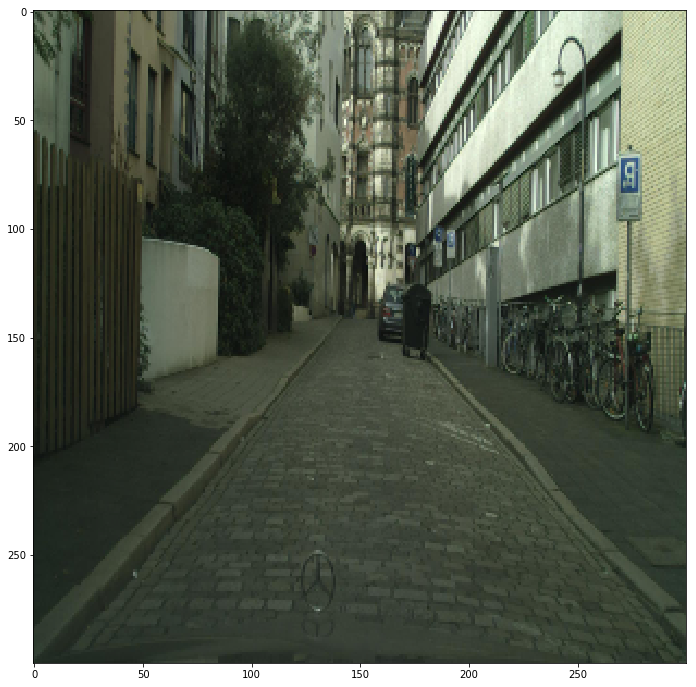

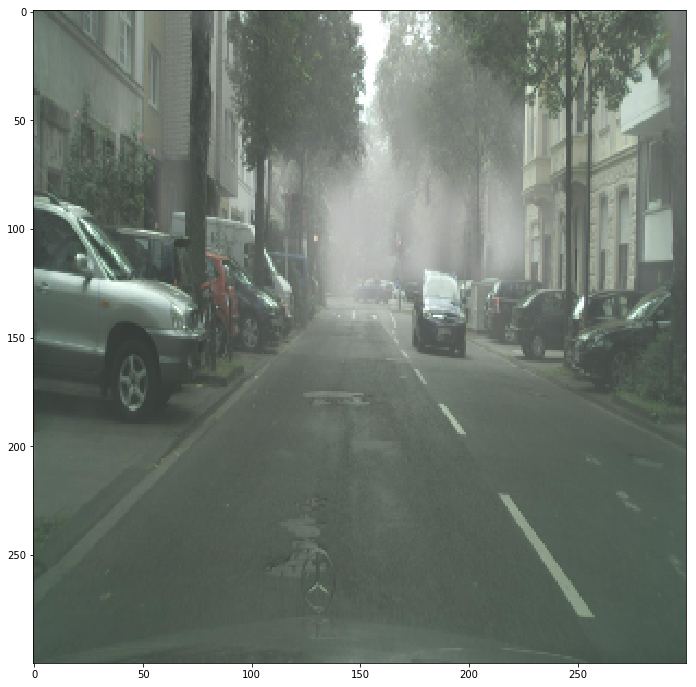

In [9]:
i = 5
print("Image:", batch_filenames[i])
colors = plt.cm.hsv(np.linspace(0, 1, n_classes+1)).tolist()
classes = ['background',
           'person', 'rider', 'car', 'truck',
           'bus', 'train', 'motorcycle', 'bicycle']

plt.figure(figsize=(20, 12))
plt.imshow(batch_images[0][i])
plt.show()
plt.figure(figsize=(20, 12))
plt.imshow(batch_images[1][i])
plt.show()


In [10]:
i = 3  # Which batch item to look at

print("Image:", batch_filenames[i])
print()
print("Ground truth boxes:\n")
print(np.array(batch_original_labels[i]))

# 3: Make predictions.

y_pred = model.predict(batch_images)[-1]

# Now let's decode the raw predictions in `y_pred`.

# Had we created the model in 'inference' or 'inference_fast' mode,
# then the model's final layer would be a `DecodeDetections` layer and
# `y_pred` would already contain the decoded predictions,
# but since we created the model in 'training' mode,
# the model outputs raw predictions that still need to be decoded and filtered.
# This is what the `decode_detections()` function is for.
# It does exactly what the `DecodeDetections` layer would do,
# but using Numpy instead of TensorFlow (i.e. on the CPU instead of the GPU).

# `decode_detections()` with default argument values follows the procedure of the original SSD implementation:
# First, a very low confidence threshold of 0.01 is applied to filter out the majority of the predicted boxes,
# then greedy non-maximum suppression is performed per class with an intersection-over-union threshold of 0.45,
# and out of what is left after that, the top 200 highest confidence boxes are returned.
# Those settings are for precision-recall scoring purposes though.
# In order to get some usable final predictions, we'll set the confidence threshold much higher, e.g. to 0.5,
# since we're only interested in the very confident predictions.

# 4: Decode the raw predictions in `y_pred`.

y_pred_decoded = decode_detections(y_pred,
                                   confidence_thresh=0.35,
                                   iou_threshold=0.4,
                                   top_k=200,
                                   normalize_coords=normalize_coords,
                                   img_height=img_height,
                                   img_width=img_width)

# We made the predictions on the resized images,
# but we'd like to visualize the outcome on the original input images,
# so we'll convert the coordinates accordingly.
# Don't worry about that opaque `apply_inverse_transforms()` function below,
# in this simple case it just applies `(* original_image_size / resized_image_size)` to the box coordinates.

# 5: Convert the predictions for the original image.

y_pred_decoded_inv = apply_inverse_transforms(y_pred_decoded, batch_inverse_transforms)

np.set_printoptions(precision=2, suppress=True, linewidth=90)
print("Predicted boxes:\n")
print('   class   conf xmin   ymin   xmax   ymax')
print(y_pred_decoded_inv[i])

# Finally, let's draw the predicted boxes onto the image.
# Each predicted box says its confidence next to the category name.
# The ground truth boxes are also drawn onto the image in green for comparison.

# 5: Draw the predicted boxes onto the image

# Set the colors for the bounding boxes
colors = plt.cm.hsv(np.linspace(0, 1, n_classes+1)).tolist()
classes = ['background',
           'person', 'rider', 'car', 'truck',
           'bus', 'train', 'motorcycle', 'bicycle']

plt.figure(figsize=(20, 12))
plt.imshow(batch_original_images[i])

current_axis = plt.gca()

for box in batch_original_labels[i]:
    xmin = box[1]
    ymin = box[2]
    xmax = box[3]
    ymax = box[4]
    label = '{}'.format(classes[int(box[0])])
    current_axis.add_patch(plt.Rectangle((xmin, ymin), xmax-xmin, ymax-ymin, color='green', fill=False, linewidth=2))
    current_axis.text(xmin, ymin, label, size='x-large', color='white', bbox={'facecolor': 'green', 'alpha': 1.0})

for box in y_pred_decoded_inv[i]:
    xmin = box[2]
    ymin = box[3]
    xmax = box[4]
    ymax = box[5]
    color = colors[int(box[0])]
    label = '{}: {:.2f}'.format(classes[int(box[0])], box[1])
    current_axis.add_patch(plt.Rectangle((xmin, ymin), xmax-xmin, ymax-ymin, color=color, fill=False, linewidth=2))
    current_axis.text(xmin, ymin, label, size='x-large', color='white', bbox={'facecolor': color, 'alpha': 1.0})

Image: ../../datasets/Cityscapes/JPEGImages/source_weimar_000041_000019_leftImg8bit

Ground truth boxes:

[[  1 380 126 389 152]
 [  1 359 123 363 132]
 [  1 302 117 321 173]
 [  1 320 120 340 172]
 [  1 340 117 360 172]
 [  1 357 120 376 175]
 [  1 239 125 247 150]
 [  1 229 123 238 150]
 [  1 203 116 228 159]
 [  3 375 136 383 150]]


TypeError: 'list' object is not callable